## Purpose
**Deploy the model to use.**

In [15]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso
import pickle

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (7,4)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

```For the EDA process of the data to be used, see:```
<br>
<sub>https://github.com/muhsinayaz/my-projects/tree/main/01-Data-Analysis-%26-Visualization-wPy/DAwPython-Capstone-AutoScout-Project</sub>

```For model selection and history, see: ```
<br>
<sub>https://github.com/muhsinayaz/my-projects/tree/main/04-Machine-Learning/ML-01-Auto-Scout-Car-Price-Prediction</sub>

In [2]:
df = pd.read_csv("part3_final_scout_not_dummy.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15909 entries, 0 to 15908
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   make_model                   15909 non-null  object 
 1   body_type                    15909 non-null  object 
 2   price                        15909 non-null  int64  
 3   km                           15909 non-null  float64
 4   type                         15909 non-null  object 
 5   previous_owners              15909 non-null  float64
 6   inspection_new               15909 non-null  int64  
 7   gearing_type                 15909 non-null  object 
 8   drive_chain                  15909 non-null  object 
 9   fuel                         15909 non-null  object 
 10  co2_emission                 15909 non-null  float64
 11  extras                       15909 non-null  object 
 12  gears                        15909 non-null  float64
 13  age             

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,15909.0,18020.241876,7377.200813,4950.0,12850.0,16900.0,21900.0,74600.0
km,15909.0,32092.436526,36982.838757,0.0,1913.0,20410.0,46900.0,317000.0
previous_owners,15909.0,1.007857,0.367974,0.0,1.0,1.0,1.0,4.0
inspection_new,15909.0,0.344145,0.475104,0.0,0.0,0.0,1.0,1.0
co2_emission,15909.0,117.782984,18.022889,45.0,104.0,117.0,129.0,253.0
gears,15909.0,5.937268,0.704675,5.0,5.0,6.0,6.0,8.0
age,15909.0,1.389591,1.121355,0.0,0.0,1.0,2.0,3.0
hp_kW,15909.0,88.493746,26.671943,40.0,66.0,85.0,103.0,294.0
displacement_cc,15909.0,1428.657364,275.852413,890.0,1229.0,1461.0,1598.0,2967.0
weight_kg,15909.0,1337.675467,199.672043,840.0,1165.0,1295.0,1472.0,2471.0


<AxesSubplot:>

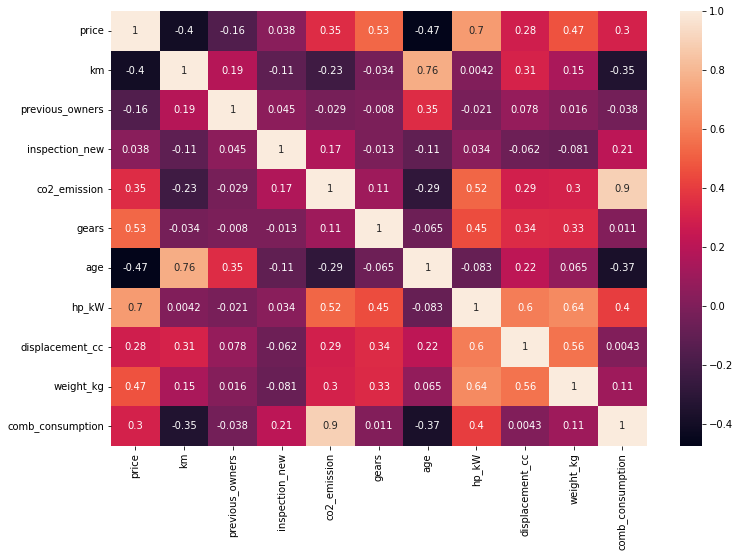

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)

In [6]:
df.describe(include="object").T

,count,unique,top,freq
make_model,15909,8,Audi A3,3093
body_type,15909,8,Sedans,8000
type,15909,5,Used,11090
gearing_type,15909,3,Manual,8148
drive_chain,15909,3,front,15701
fuel,15909,3,Benzine,8548
extras,15909,659,Alloy wheels,5782
upholstery_type,15909,2,Cloth,12319
comfort_convenience_package,15909,3,Standard,10778
entertainment_media_package,15909,2,Plus,10803


In [8]:
print("Number of Uniques:\n", df.select_dtypes('object').nunique(),'\n', sep='')

Number of Uniques:
make_model                       8
body_type                        8
type                             5
gearing_type                     3
drive_chain                      3
fuel                             3
extras                         659
upholstery_type                  2
comfort_convenience_package      3
entertainment_media_package      2
safety_security_package          3
dtype: int64



In [9]:
print("Number of Uniques:\n", df.select_dtypes('number').nunique(), '\n', sep='')

Number of Uniques:
price               2951
km                  6689
previous_owners        5
inspection_new         2
co2_emission         113
gears                  4
age                    4
hp_kW                 77
displacement_cc       68
weight_kg            432
comb_consumption      62
dtype: int64



## Model Selection-Feature Importance
- In our previous project, we chose the Lasso model with the first 6 important features.

In [29]:
for model in df.make_model.unique():
    
    car_prices = df[df["make_model"]== model]["price"]
    
    Q1 = car_prices.quantile(0.25)
    Q3 = car_prices.quantile(0.75)
    
    IQR = Q3-Q1
    
    lower_lim = Q1-1.5*IQR
    upper_lim = Q3+1.5*IQR

    drop_index = df[df["make_model"]== model][(car_prices < lower_lim) | (car_prices > upper_lim)].index
    df.drop(index = drop_index, inplace=True)
    df.reset_index(drop=True, inplace=True)
df.head()

,make_model,body_type,price,km,type,previous_owners,inspection_new,gearing_type,drive_chain,fuel,co2_emission,extras,gears,age,hp_kW,upholstery_type,displacement_cc,weight_kg,comb_consumption,comfort_convenience_package,entertainment_media_package,safety_security_package
0,Audi A1,Sedans,15770,56013.0,Used,2.0,1,Automatic,front,Diesel,99.0,"Alloy wheels, Catalytic Converter, Voice Control",7.0,3.0,66.0,Cloth,1422.0,1220.0,3.8,Premium,Plus,Safety Premium Package
1,Audi A1,Sedans,14500,80000.0,Used,2.0,0,Automatic,front,Benzine,129.0,"Alloy wheels, Sport seats, Sport suspension, V...",7.0,2.0,141.0,Cloth,1798.0,1255.0,5.6,Standard,Plus,Safety Premium Package
2,Audi A1,Sedans,14640,83450.0,Used,1.0,0,Automatic,front,Diesel,99.0,"Alloy wheels, Voice Control",7.0,3.0,85.0,Cloth,1598.0,1135.0,3.8,Premium,Standard,Safety Premium Package
3,Audi A1,Sedans,14500,73000.0,Used,1.0,0,Automatic,front,Diesel,99.0,"Alloy wheels, Sport seats, Voice Control",6.0,3.0,66.0,Cloth,1422.0,1195.0,3.8,Standard,Plus,Safety Premium Package
4,Audi A1,Sedans,16790,16200.0,Used,1.0,1,Automatic,front,Diesel,109.0,"Alloy wheels, Sport package, Sport suspension,...",7.0,3.0,66.0,Cloth,1422.0,1135.0,4.1,Premium,Plus,Safety Premium Package


In [30]:
df_new = df[["make_model", "hp_kW", "km","age", "gearing_type", "gears", "type", "price"]]

In [31]:
X = df_new.drop("price", axis=1)
y = df_new["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
cat = X_train.select_dtypes("object").columns
num = X_train.select_dtypes("number").columns
cat, num

(Index(['make_model', 'gearing_type', 'type'], dtype='object'),
 Index(['hp_kW', 'km', 'age', 'gears'], dtype='object'))

In [33]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
scaler = MinMaxScaler()
column_trans = make_column_transformer((encoder, cat), (scaler, num), remainder="passthrough")

operations = [("Scaler_Encoder", column_trans), ("Lasso", Lasso(alpha=1.02))]

model = Pipeline(steps=operations)
model.fit(X_train, y_train)

Pipeline(steps=[('Scaler_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['make_model', 'gearing_type', 'type'], dtype='object')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['hp_kW', 'km', 'age', 'gears'], dtype='object'))])),
                ('Lasso', Lasso(alpha=1.02))])

In [35]:
def train_val(model, X_train, y_train, X_test, y_test):
    """This function will help you get regression metrics on both train
    and test set provided. 

    Args:
        model : model that is used for prediction
        X_train : Train features
        y_train : Train target
        X_test  : Test features
        y_test  : Test target

    Returns:
        Dataframe : Returns scores dataframe
    """
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [37]:
pd.options.display.float_format = '{:.3f}'.format

In [38]:
train_val(model, X_train, y_train, X_test, y_test)

,train,test
R2,0.880,0.887
mae,1668.791,1604.427
mse,5530415.120,5050768.319
rmse,2351.683,2247.391


## Prediction a new observation
- Create an observation and predict its price

In [39]:
X = df_new.drop(columns = ["price"])
y = df_new.price

In [40]:
X.head()

,make_model,hp_kW,km,age,gearing_type,gears,type
0,Audi A1,66.000,56013.000,3.000,Automatic,7.000,Used
1,Audi A1,141.000,80000.000,2.000,Automatic,7.000,Used
2,Audi A1,85.000,83450.000,3.000,Automatic,7.000,Used
3,Audi A1,66.000,73000.000,3.000,Automatic,6.000,Used
4,Audi A1,66.000,16200.000,3.000,Automatic,7.000,Used


In [41]:
column_trans = make_column_transformer((encoder, cat), (scaler, num), remainder="passthrough")
operations = [("Scaler_Encoder", column_trans), ("Lasso", Lasso(alpha=1.02))]
final_model = Pipeline(operations)
final_model.fit(X,y)

Pipeline(steps=[('Scaler_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['make_model', 'gearing_type', 'type'], dtype='object')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['hp_kW', 'km', 'age', 'gears'], dtype='object'))])),
                ('Lasso', Lasso(alpha=1.02))])

## Model Deployment

In [42]:
pickle.dump(final_model, open("lasso_model", "wb"))

In [43]:
prediction = pickle.load(open("lasso_model", "rb"))

In [47]:
df.tail().T

,15488,15489,15490,15491,15492
make_model,Renault Espace,Renault Espace,Renault Espace,Renault Espace,Renault Espace
body_type,Van,Van,Van,Van,Van
price,39950,39885,39875,39700,40999
km,1647.363,9900.000,15.000,10.000,1647.363
type,New,Used,Pre-registered,Pre-registered,Demonstration
previous_owners,1.000,1.000,1.000,1.000,1.000
inspection_new,0,1,1,0,1
gearing_type,Automatic,Automatic,Automatic,Automatic,Automatic
drive_chain,front,front,front,front,4WD
fuel,Diesel,Benzine,Diesel,Diesel,Benzine


In [48]:
prediction.predict(df.tail())
# Model quality was neglected in this study!

array([35385.77975291, 35929.19270971, 34485.77752371, 34560.83688074,
       38324.99112223])